## Importing libraries

In [2]:
# loading data
import urllib.request

# data manipulation
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
# enable interactive plot in the notebook
%matplotlib notebook

# machine learning methods
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

## Loading and formatting the data

In [3]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/undergroundWater?station_id=85069";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
df = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
df['Date'] = df['LastUpdatedEpoch'];
df['Date'] = pd.to_datetime(df['Date'], unit='ms');

# remove unneccessary fields
df.drop('LastUpdated', 1, inplace=True);
df.drop('LastUpdatedEpoch', 1, inplace=True);
df.drop('Region_id', 1, inplace=True);
df.drop('Region_name', 1, inplace=True);
df.drop('Station_id', 1, inplace=True);
df.drop('Station_name', 1, inplace=True);
df.drop('SystemCodeNumber', 1, inplace=True);

## Checking loaded data

In [4]:
# string/tabular view
# len(jsonStr), jsonStr[0:100] and df[0:5]
df[0:5]

,Value,Date
0,277.80,2015-01-01
1,277.77,2015-01-02
2,277.73,2015-01-03
3,277.70,2015-01-04
4,277.65,2015-01-05


<IPython.core.display.Javascript object>


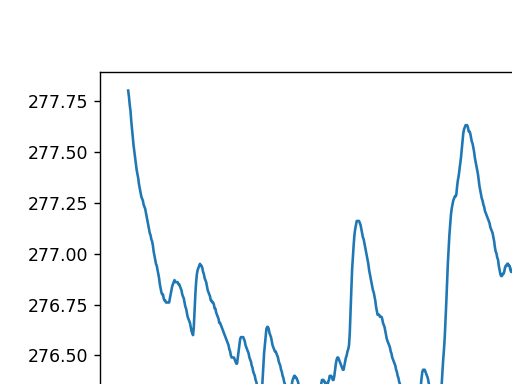

In [5]:
# plotting the data
# format date axis
fig, ax = plt.subplots(); fig.autofmt_xdate();
# plot
ax.plot(df['Date'], df['Value']);
# show plot
plt.show();

## Loading some additional data for modeling (weather)

In [6]:
# API URL to underground water levels in Ljubljana aquifer
# station with id 85076 is 1279238400Lj - RTV (0261) Ljubljansko polje
url = "http://atena.ijs.si:8080/CollectorAPIServer/weather?time_from=31/12/2014&time_to=01/01/2017&city=Ljubljana";
jsonStr = urllib.request.urlopen(url).read().decode('utf-8');
dw = pd.read_json(jsonStr);

# converting unix timestamp to date-time object
dw['Date'] = dw['LastUpdatedEpoch'];
dw['Date'] = pd.to_datetime(dw['Date'] + 2 * 60 * 60 * 1000, unit='ms').dt.round("1d");
dw.set_index('Date', inplace=True);

dw.drop('City', 1, inplace=True);
dw.drop('LastUpdated', 1, inplace=True);
dw.drop('LastUpdatedEpoch', 1, inplace=True);
dw.drop('Sensor_id', 1, inplace=True);
dw.drop('Sensor_name', 1, inplace=True);
dw.drop('SystemCodeNumber', 1, inplace=True);


In [7]:
dw[0:5]

,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin
Date,,,,,,,,
2015-01-01,70,0,0.0,13,2.1,-5.8,-3.0,-9.6
2015-01-02,83,0,0.0,12,2.1,-0.6,1.5,-5.5
2015-01-03,80,0,0.0,10,0.0,-1.0,0.6,-4.5
2015-01-04,20,0,0.2,8,7.9,3.1,10.3,-0.5
2015-01-05,50,0,0.0,4,5.9,3.0,8.5,0.0


## Data Fusion

In [8]:
# make date a key in our data
df.set_index('Date', inplace=True);

In [9]:
df[0:5]

,Value
Date,
2015-01-01,277.80
2015-01-02,277.77
2015-01-03,277.73
2015-01-04,277.70
2015-01-05,277.65


In [10]:
# generate fused dataset
ds = pd.concat([df, dw], axis=1);

In [11]:
# let's check it
ds[0:10]

,Value,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin
Date,,,,,,,,,
2015-01-01,277.80,70,0,0.0,13,2.1,-5.8,-3.0,-9.6
2015-01-02,277.77,83,0,0.0,12,2.1,-0.6,1.5,-5.5
2015-01-03,277.73,80,0,0.0,10,0.0,-1.0,0.6,-4.5
2015-01-04,277.70,20,0,0.2,8,7.9,3.1,10.3,-0.5
2015-01-05,277.65,50,0,0.0,4,5.9,3.0,8.5,0.0
2015-01-06,277.61,33,0,0.0,3,4.4,-0.4,4.9,-3.6
2015-01-07,277.57,50,0,0.0,3,1.1,-0.9,2.7,-2.7
2015-01-08,277.53,83,0,0.0,3,0.2,0.2,2.3,-4.1
2015-01-09,277.50,90,0,0.0,2,0.6,4.9,7.5,1.0


# .........

In [12]:
ds['DValue'] = ds['Value'] - ds['Value'].shift(1)

In [13]:
#dnew = ds
#for i in range(26):
#    dnew['Sun_duration' + '_shift_' + str(i)+'d'] = ds['Sun_duration'].shift(i)
#for i in range(50,101,10):
#    dnew['Sun_duration' + '_shift_' + str(i)+'d'] = ds['Sun_duration'].shift(i)

In [14]:
#shift of data for n days
def shift_of_data(string, data, new_data):
    for i in range(26):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)
    for i in range(30,101,10):
        new_data[string + '_shift_' + str(i)+'d'] = data[string].shift(i)

In [15]:
import copy
dnew = copy.deepcopy(ds)

data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

for string in data_names:
    shift_of_data(string, ds, dnew)

In [16]:
dnew

,Value,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin,DValue,...,TemperatureMin_shift_24d,TemperatureMin_shift_25d,TemperatureMin_shift_30d,TemperatureMin_shift_40d,TemperatureMin_shift_50d,TemperatureMin_shift_60d,TemperatureMin_shift_70d,TemperatureMin_shift_80d,TemperatureMin_shift_90d,TemperatureMin_shift_100d
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,277.80,70,0,0.0,13,2.1,-5.8,-3.0,-9.6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,277.77,83,0,0.0,12,2.1,-0.6,1.5,-5.5,-0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,277.73,80,0,0.0,10,0.0,-1.0,0.6,-4.5,-0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,277.70,20,0,0.2,8,7.9,3.1,10.3,-0.5,-0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,277.65,50,0,0.0,4,5.9,3.0,8.5,0.0,-0.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,277.61,33,0,0.0,3,4.4,-0.4,4.9,-3.6,-0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,277.57,50,0,0.0,3,1.1,-0.9,2.7,-2.7,-0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,277.53,83,0,0.0,3,0.2,0.2,2.3,-4.1,-0.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-09,277.50,90,0,0.0,2,0.6,4.9,7.5,1.0,-0.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
dnew.corr()

,Value,CloudCover,New_snow_blanket,Percipitation,Snow_blanket,Sun_duration,TemperatureAvg,TemperatureMax,TemperatureMin,DValue,...,TemperatureMin_shift_24d,TemperatureMin_shift_25d,TemperatureMin_shift_30d,TemperatureMin_shift_40d,TemperatureMin_shift_50d,TemperatureMin_shift_60d,TemperatureMin_shift_70d,TemperatureMin_shift_80d,TemperatureMin_shift_90d,TemperatureMin_shift_100d
Value,1.000000,-0.003858,-0.002169,-0.074592,0.064040,-0.014578,-0.178222,-0.162254,-0.206844,-0.051989,...,-0.281491,-0.287373,-0.316469,-0.359522,-0.418450,-0.447962,-0.432430,-0.417011,-0.403202,-0.361573
CloudCover,-0.003858,1.000000,0.122452,0.219788,0.162879,-0.832740,-0.315040,-0.429054,-0.138423,0.213588,...,-0.173422,-0.166982,-0.119626,-0.112790,-0.065826,-0.011018,0.005857,0.032737,0.060471,0.078929
New_snow_blanket,-0.002169,0.122452,1.000000,0.182088,0.518093,-0.111978,-0.162496,-0.171834,-0.143569,-0.023698,...,-0.139878,-0.128508,-0.123973,-0.103793,-0.059714,-0.067943,-0.050597,-0.022405,0.000624,-0.030393
Percipitation,-0.074592,0.219788,0.182088,1.000000,0.029835,-0.178188,-0.010982,-0.044188,0.062845,0.328638,...,0.053165,0.021458,0.015628,0.028124,0.040628,0.011282,0.010889,-0.026575,0.007282,-0.050968
Snow_blanket,0.064040,0.162879,0.518093,0.029835,1.000000,-0.178759,-0.305313,-0.317375,-0.294889,-0.123140,...,-0.197011,-0.201968,-0.231135,-0.232043,-0.065711,-0.087937,-0.050658,-0.043067,0.028343,-0.007481
Sun_duration,-0.014578,-0.832740,-0.111978,-0.178188,-0.178759,1.000000,0.596189,0.683709,0.407157,-0.126903,...,0.356407,0.348565,0.285265,0.219850,0.155838,0.056702,-0.025394,-0.114992,-0.196478,-0.267138
TemperatureAvg,-0.178222,-0.315040,-0.162496,-0.010982,-0.305313,0.596189,1.000000,0.979318,0.957507,-0.063458,...,0.714557,0.706291,0.643605,0.588929,0.433107,0.329767,0.167204,0.033856,-0.164478,-0.289784
TemperatureMax,-0.162254,-0.429054,-0.171834,-0.044188,-0.317375,0.683709,0.979318,1.000000,0.906927,-0.090399,...,0.695485,0.688403,0.623542,0.568491,0.421246,0.304561,0.156162,0.020409,-0.160841,-0.291403
TemperatureMin,-0.206844,-0.138423,-0.143569,0.062845,-0.294889,0.407157,0.957507,0.906927,1.000000,-0.019962,...,0.717036,0.713130,0.665200,0.622597,0.462529,0.380717,0.229227,0.091839,-0.113400,-0.232108
DValue,-0.051989,0.213588,-0.023698,0.328638,-0.123140,-0.126903,-0.063458,-0.090399,-0.019962,1.000000,...,-0.059203,-0.064819,-0.057347,-0.056276,-0.087917,-0.015223,0.046846,-0.006664,0.059899,0.047010


In [18]:
#correlation for shifts
#plt.matshow(dnew.corr())

In [19]:
#average for last n days
def average_last_n_days(string, data, new_data):
    for i in range(26):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i
    for i in range(30,101,10):
        new_data[string + '_average_' + str(i)+'d'] = data[string].rolling(i).sum()/i

In [20]:
#for i in range(26):
#    dnew['Sun_duration' + '_sum_' + str(i)+'d'] = ds['Sun_duration'].rolling(i).sum()

In [21]:
#data_names = ['CloudCover', 'New_snow_blanket', 'Percipitation','Snow_blanket',
#              'Sun_duration', 'TemperatureAvg', 'TemperatureMax', 'TemperatureMin']

#dnew2 = copy.deepcopy(ds)
for string in data_names:
    average_last_n_days(string, ds, dnew)  

In [22]:
#dnew2.corr()

<IPython.core.display.Javascript object>


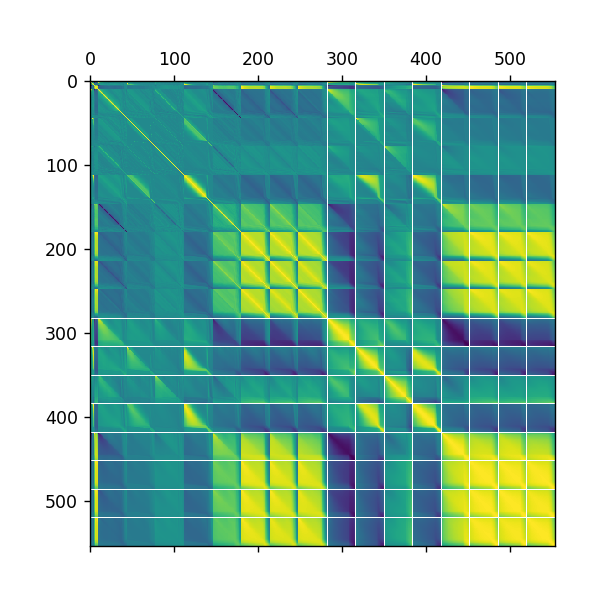

In [23]:
# correlation for shifts and average
plt.matshow(dnew.corr())Cl

In [29]:
dnew.corr()['DValue']

Value                           -0.051989
CloudCover                       0.213588
New_snow_blanket                -0.023698
Percipitation                    0.328638
Snow_blanket                    -0.123140
Sun_duration                    -0.126903
TemperatureAvg                  -0.063458
TemperatureMax                  -0.090399
TemperatureMin                  -0.019962
DValue                           1.000000
CloudCover_shift_0d              0.213588
CloudCover_shift_1d              0.278420
CloudCover_shift_2d              0.348230
CloudCover_shift_3d              0.377078
CloudCover_shift_4d              0.342945
CloudCover_shift_5d              0.313201
CloudCover_shift_6d              0.280046
CloudCover_shift_7d              0.260291
CloudCover_shift_8d              0.228104
CloudCover_shift_9d              0.199504
CloudCover_shift_10d             0.167226
CloudCover_shift_11d             0.161388
CloudCover_shift_12d             0.151673
CloudCover_shift_13d             0

In [30]:
# sort for corelation with 'DValue' from max to min
dsort = dnew.corr().sort_values(['DValue'], ascending = False)

In [31]:
pd.set_option('display.max_rows', 1000)
dsort['DValue']

DValue                           1.000000
Percipitation_average_6d         0.783874
Percipitation_average_7d         0.778615
Percipitation_average_8d         0.772410
Percipitation_average_5d         0.772055
Percipitation_average_9d         0.762098
Percipitation_average_10d        0.740993
Percipitation_average_4d         0.740316
Percipitation_average_11d        0.718342
Percipitation_average_12d        0.696839
Percipitation_average_13d        0.677758
Percipitation_average_3d         0.664812
Percipitation_average_14d        0.661032
Percipitation_average_15d        0.652817
Percipitation_average_16d        0.637825
Percipitation_average_17d        0.618096
Percipitation_average_18d        0.602688
Percipitation_average_19d        0.592388
Percipitation_average_20d        0.582812
Percipitation_average_21d        0.571892
Percipitation_average_22d        0.561002
Percipitation_average_23d        0.549973
Percipitation_average_24d        0.535254
Percipitation_average_2d         0

<IPython.core.display.Javascript object>


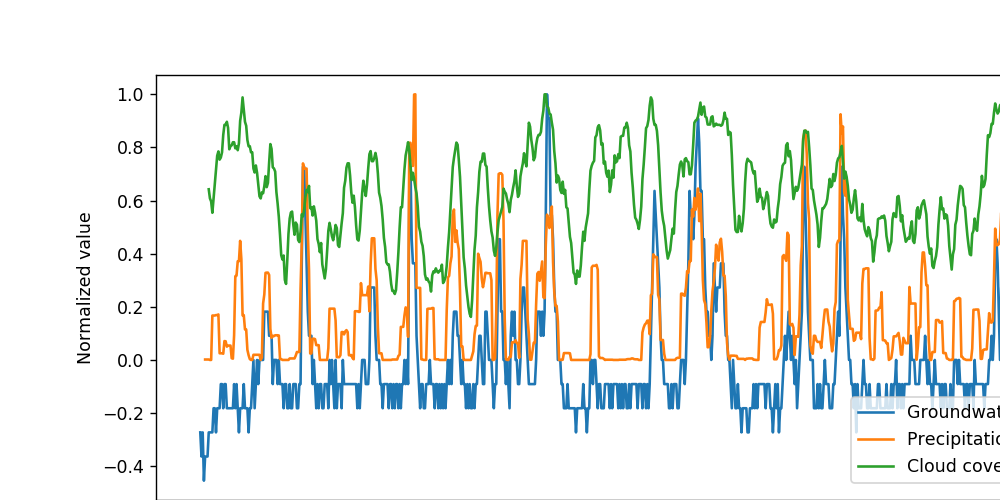

In [65]:
# ploted corelated quantities
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(731), dnew['DValue'] / np.max(np.abs(dnew['DValue']),axis=0), label="Groundwater change");
ax.plot(range(731), dnew['Percipitation_average_6d'] / np.max(np.abs(dnew['Percipitation_average_6d']),axis=0), label="Precipitation avg. (6d)");
ax.plot(range(731), dnew['CloudCover_average_9d'] / np.max(np.abs(dnew['CloudCover_average_9d']),axis=0), label="Cloud cover avg. (9d)");
ax.legend(loc=4, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Normalized value')
plt.show();

In [66]:
fig.savefig('correlations.png', dpi=300)

In [67]:
#create new data frame for chosen colerated quantities
data_corelated = pd.DataFrame()
corelated = ['Percipitation_average_6d',
             'Percipitation_average_10d',
             'Percipitation_average_25d',
             'CloudCover_average_9d',
             'Sun_duration_average_9d'
            ]
data_corelated['DValue'] = copy.deepcopy(dnew['DValue'])

for corelated in corelated:
    data_corelated[corelated] = copy.deepcopy(dnew[corelated])


In [145]:
data_corelated

,DValue,Percipitation_average_6d,Percipitation_average_10d,Percipitation_average_25d,CloudCover_average_9d,Sun_duration_average_9d
Date,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-0.03,NaN,NaN,NaN,NaN,NaN
2015-01-03,-0.04,NaN,NaN,NaN,NaN,NaN
2015-01-04,-0.03,NaN,NaN,NaN,NaN,NaN
2015-01-05,-0.05,NaN,NaN,NaN,NaN,NaN
2015-01-06,-0.04,3.333333e-02,NaN,NaN,NaN,NaN
2015-01-07,-0.04,3.333333e-02,NaN,NaN,NaN,NaN
2015-01-08,-0.04,3.333333e-02,NaN,NaN,NaN,NaN
2015-01-09,-0.03,3.333333e-02,NaN,NaN,62.111111,2.700000


# Learn

In [96]:
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import Normalizer

from sklearn.metrics import mean_squared_error, r2_score

In [70]:
#create arrays x (corelated) and y ('DValue')
#y = dnew['Value']
y = data_corelated['DValue']
y = y.values.astype(np.float)[30:]
X = data_corelated.iloc[:, 1:len(corelated)]
X= X.values.astype(np.float)[30:]

In [71]:
y.shape

(701,)

In [72]:
#choose regressor

regressor = linear_model.LinearRegression();
regressor = DecisionTreeRegressor();
regressor = RandomForestRegressor();
regressor = SVR();
regressor = GradientBoostingRegressor();

In [73]:
#predict
predicted = cross_val_predict(regressor, X, y, cv = 3)

<IPython.core.display.Javascript object>


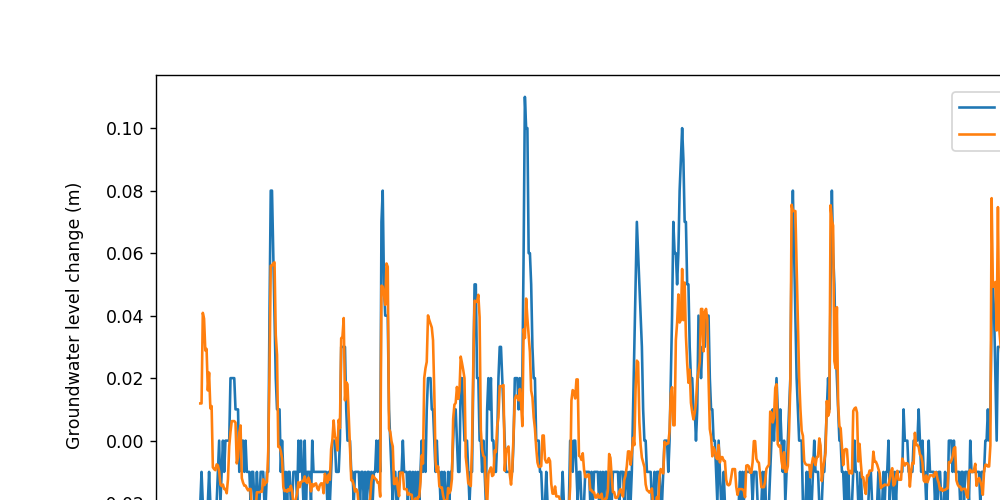

In [90]:
#plot predicted values and real value
fig, ax = plt.subplots(); 
#fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(701), y, label="True value")
ax.plot(range(701), predicted, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level change (m)')
plt.show();

In [91]:
fig.savefig('prediction.png', dpi=300)

In [126]:
#evaluate results

mse = mean_squared_error(y, predicted)
r2 = r2_score(y, predicted);
(mse, r2)

(0.00021973654394672322, 0.6290705240204577)

In [95]:
#evaluation for all regressors
regressor_list = (linear_model.LinearRegression(),
            DecisionTreeRegressor(),
            RandomForestRegressor(),
            SVR(),
            MLPRegressor(),
            GradientBoostingRegressor())

for regressor in regressor_list:
    predicted = cross_val_predict(regressor, X, y, cv = 3)
    mse = mean_squared_error(y, predicted)
    r2 = r2_score(y, predicted);
    print(mse, r2)

0.000222915395822 0.623704416777
0.000346362339515 0.415318004062
0.000231376248217 0.609421951562
0.00225577746077 -2.80789802379
3.94800160247 -6663.48165274
0.000210878842427 0.644022896185


In [85]:
#sum
value = ds['Value']
value = value.values.astype(np.float)[30:]

predicted_value = []
predicted_value.append(value[0])
n=1
for i in predicted[1:]:
    predicted_value.append(predicted_value[n-1] + i)
    n += 1

<IPython.core.display.Javascript object>


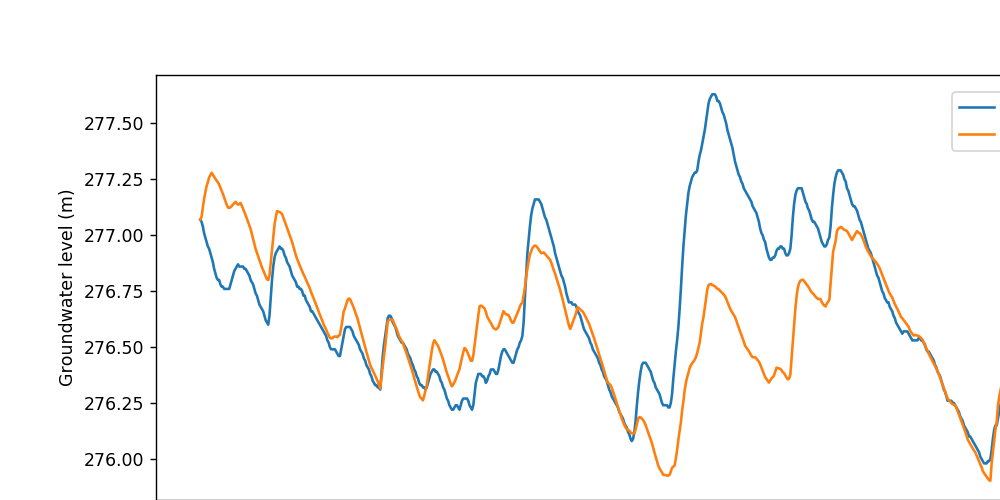

In [92]:
fig, ax = plt.subplots(); fig.autofmt_xdate();
fig.set_size_inches(10, 5)
ax.plot(range(701), value, label="True value");
ax.plot(range(701), predicted_value, label="Prediction");
ax.legend(loc=1, borderaxespad=1)
plt.xlabel('Time (days)')
plt.ylabel('Groundwater level (m)')
plt.show();

In [93]:
fig.savefig('prediction_cum.png', dpi=300)